First we need to download the extract the dataset. The dataset will be extracted under ```/tmp/PetImages```, where there will be two directories ```Cat```and ```Dog```, each containing 12500 images.

In [1]:
# Let's make sure Keras is installed
import sys
!{sys.executable} -m pip install keras > /dev/null
import matplotlib.pyplot as plt
import numpy as np
!cd /tmp/ && wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

--2019-04-13 15:38:38--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.26.80.188, 2600:1409:3000:4a4::e59, 2600:1409:3000:48e::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.26.80.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M  8.41MB/s    in 1m 41s  

2019-04-13 15:40:20 (7.77 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



In [61]:
!cd /tmp/ && rm PetImages -rf && unzip -o kagglecatsanddogs_3367a.zip > /dev/null
!cd /tmp/PetImages/Cat/ && cp 5534.jpg 666.jpg
!cd /tmp/PetImages/Dog/ && cp 1000.jpg 11702.jpg

For the sake of training speed, we are going to create a smaller dataset contining 1000 images of each class for the training dataset, 500 for the validation dataset and 500 for the test dataset.

In [62]:
import os, shutil

def create_dir(dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

base_dir = os.path.join('/', 'tmp', 'small_dataset')
create_dir(base_dir)

dirs = [('train', 1000), ('validation', 500), ('test', 500)]
idx = 0
for d in dirs:
    # Create directores
    dir = os.path.join(base_dir, d[0])
    dir_cats = os.path.join(dir, 'cats')
    dir_dogs = os.path.join(dir, 'dogs')
    create_dir(dir)
    create_dir(dir_cats)
    create_dir(dir_dogs)
    
    # Copy the required number of cats and dogs images
    fnames = ['{}.jpg'.format(i) for i in range(idx, idx + d[1])]
    for fname in fnames:
        src = os.path.join('/', 'tmp', 'PetImages','Cat', fname)
        dst = os.path.join(dir_cats, fname)
        shutil.copyfile(src, dst)
        
    for fname in fnames:
        src = os.path.join('/', 'tmp', 'PetImages','Dog', fname)
        dst = os.path.join(dir_dogs, fname)
        shutil.copyfile(src, dst)
    idx = idx + d[1]
    print('Cat Images {}: '.format(d[0]), len(os.listdir(dir_cats)))
    print('Dog Images {}: '.format(d[0]), len(os.listdir(dir_dogs)))

Cat Images train:  1000
Dog Images train:  1000
Cat Images validation:  500
Dog Images validation:  500
Cat Images test:  500
Dog Images test:  500


# Building the network

We begin by defining the network structure

In [63]:
from keras import layers, models

net = models.Sequential()
net.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150,3)))
net.add(layers.MaxPool2D((2, 2)))
net.add(layers.Conv2D(64, (3, 3), activation='relu'))
net.add(layers.MaxPool2D((2, 2)))
net.add(layers.Conv2D(128, (3, 3), activation='relu'))
net.add(layers.MaxPool2D((2, 2)))
net.add(layers.Conv2D(128, (3, 3), activation='relu'))
net.add(layers.MaxPool2D((2, 2)))
net.add(layers.Flatten())
net.add(layers.Dense(512, activation='relu'))
net.add(layers.Dense(1, activation='sigmoid'))
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 15, 15, 128)       147584    
__________

and finally compile the network, for which we need to define a loss function and an optimizer

In [64]:
from keras import optimizers

net.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4),
            metrics=['acc'])

Before we can train our model, we need to pre-process the data. In this case we want to normalize the values in the range $[0, 1]$, and resize the images to $(150, 150)$ pixels

In [65]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')
validation_generator = test_datagen.flow_from_directory(test_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Training

Finally we are ready to train our model

In [66]:
history = net.fit_generator(train_generator, 
                            steps_per_epoch=100, 
                            epochs=30, 
                            validation_data=validation_generator,
                            validation_steps=50)

Epoch 1/30
  2/100 [..............................] - ETA: 2:40 - loss: 0.7395 - acc: 0.4750

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (si

100/100 [==============================] - 51s 507ms/step - loss: 0.6915 - acc: 0.5295 - val_loss: 0.6860 - val_acc: 0.5150
Epoch 2/30
100/100 [==============================] - 49s 493ms/step - loss: 0.6578 - acc: 0.6080 - val_loss: 0.6500 - val_acc: 0.6250
Epoch 3/30
100/100 [==============================] - 48s 478ms/step - loss: 0.6168 - acc: 0.6640 - val_loss: 0.6188 - val_acc: 0.6740
Epoch 4/30
100/100 [==============================] - 48s 477ms/step - loss: 0.5783 - acc: 0.6945 - val_loss: 0.6276 - val_acc: 0.6350
Epoch 5/30
100/100 [==============================] - 49s 495ms/step - loss: 0.5344 - acc: 0.7330 - val_loss: 0.5794 - val_acc: 0.7030
Epoch 6/30
100/100 [==============================] - 48s 478ms/step - loss: 0.4921 - acc: 0.7690 - val_loss: 0.5733 - val_acc: 0.7020
Epoch 7/30
100/100 [==============================] - 48s 478ms/step - loss: 0.4712 - acc: 0.7780 - val_loss: 0.5623 - val_acc: 0.7230
Epoch 8/30
100/100 [==============================] - 48s 477ms/st

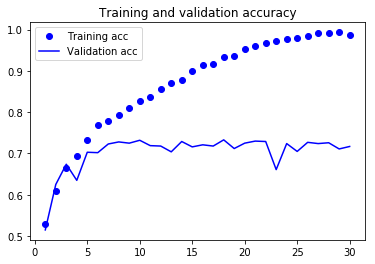

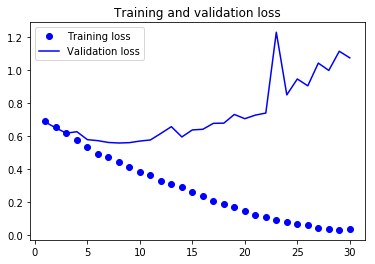

In [74]:
import matplotlib.pyplot as plt

def generat_plots(history):
    acc = history.history['acc']
    validation_acc = history.history['val_acc']
    loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # for plotting purposes we consider the first epoch to be the
    # number 1, and not 0 as we would normally index an array
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, validation_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, validation_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
generat_plots(history)

There is clearly overfit. We are going to use data augmentation to address this situation

# Data Augmentation

Basically, data augmentation generates new samples by modifying existing ones. In the following example we are going to also use Dropout to further fight overfitting. Although the images we are using are all different, many come from the same original image, so overfitting is still a concern.

In [70]:
net = models.Sequential()
net.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150,3)))
net.add(layers.MaxPool2D((2, 2)))
net.add(layers.Conv2D(64, (3, 3), activation='relu'))
net.add(layers.MaxPool2D((2, 2)))
net.add(layers.Conv2D(128, (3, 3), activation='relu'))
net.add(layers.MaxPool2D((2, 2)))
net.add(layers.Conv2D(128, (3, 3), activation='relu'))
net.add(layers.MaxPool2D((2, 2)))
net.add(layers.Flatten())
net.add(layers.Dropout(0.5))
net.add(layers.Dense(512, activation='relu'))
net.add(layers.Dense(1, activation='sigmoid'))
net.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 17, 17, 128)       0         
___________________________

In [79]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')
validation_generator = test_datagen.flow_from_directory(test_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
net.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4),
            metrics=['acc'])

history_aug = net.fit_generator(train_generator, 
                            steps_per_epoch=100, 
                            epochs=100, 
                            validation_data=validation_generator,
                            validation_steps=50)
generat_plots(history_aug)

Epoch 1/100
 34/100 [=========>....................] - ETA: 54s - loss: 0.6843 - acc: 0.5441

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (si

100/100 [==============================] - 93s 925ms/step - loss: 0.6712 - acc: 0.5841 - val_loss: 0.6589 - val_acc: 0.6034
Epoch 2/100
100/100 [==============================] - 87s 871ms/step - loss: 0.6602 - acc: 0.6066 - val_loss: 0.7528 - val_acc: 0.5387
Epoch 3/100
100/100 [==============================] - 87s 873ms/step - loss: 0.6541 - acc: 0.6106 - val_loss: 0.6270 - val_acc: 0.6415
Epoch 4/100
100/100 [==============================] - 87s 874ms/step - loss: 0.6366 - acc: 0.6306 - val_loss: 0.6124 - val_acc: 0.6894
Epoch 5/100
100/100 [==============================] - 88s 878ms/step - loss: 0.6205 - acc: 0.6581 - val_loss: 0.6162 - val_acc: 0.6491
Epoch 6/100
100/100 [==============================] - 88s 879ms/step - loss: 0.6121 - acc: 0.6566 - val_loss: 0.5923 - val_acc: 0.6959
Epoch 7/100
100/100 [==============================] - 87s 872ms/step - loss: 0.5915 - acc: 0.6881 - val_loss: 0.6568 - val_acc: 0.6358
Epoch 8/100
100/100 [==============================] - 88s 8